Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><h1 style="text-align: center; vertical-align: middle;"><a href="https://moodle.polytechnique.fr/course/view.php?id=15585">[CSE204-2022] - Introduction to Machine Learning</a></h1>
</td>
  </tr>
</table>

---

# Lab Session 2: parametric models

Jérémie DECOCK - Adrien EHRHARDT

## Objectives

- Introduction to parametric models
- Calculate by hand a linear regression
- Implement a linear regressor using gradient descent
- Linear regression with Scikit Learn
- Implement a polynomial regressor with Scikit Learn

## Imports and tool functions

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import axes3d

import sklearn
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing

Read carefully the function definitions below; we'll use them to generate and plot some data which will be the subject of subsequent questions.

In [ ]:
def gen_1d_linear_regression_samples(n_samples: int = 20) -> pd.DataFrame:
    """
    Generate one-dimensional linear regression samples

    :param int n_samples: number of samples to generate
    """
    x = np.random.uniform(low=-10., high=10., size=n_samples)
    y = 4. * x + 2. + np.random.normal(scale=2., size=x.shape)
    df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    df = sklearn.utils.shuffle(df).reset_index(drop=True)
    return df


def gen_1d_polynomial_regression_samples(n_samples: int = 15) -> pd.DataFrame:
    """
    Generate one-dimensional polynomial regression samples

    :param int n_samples: number of samples to generate
    """
    x = np.random.uniform(low=0., high=10., size=n_samples)
    y = 2. - 3. * x - x ** 2 + x ** 3 + np.random.normal(scale=10., size=x.shape)
    df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    df = sklearn.utils.shuffle(df).reset_index(drop=True)
    return df


def plot_1d_regression_samples(dataframe: pd.DataFrame, model=None):
    """
    Plot the regression samples in one-D with the predictions if model is provided

    :param pandas.DataFrame dataframe: a dataframe containing the :code:`x` feature and
        :code:`y` dependent feature to regress on.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    df = dataframe.copy()  # make an alias

    ERROR_MSG1 = "The `dataframe` parameter should be a Pandas DataFrame having the following columns: ['x', 'y']"
    assert df.columns.values.tolist() == ['x', 'y'], ERROR_MSG1

    if model is not None:
        # Compute the model's prediction
        x_pred = np.linspace(df.x.min(), df.x.max(), 100).reshape(-1, 1)
        y_pred = model.predict(pd.DataFrame(x_pred, columns=['x']))
        df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])
        df_pred.plot(x='x', y='y', style='r--', ax=ax)

    # Plot also the training points
    df.plot.scatter(x='x', y='y', ax=ax)
    delta_y = df.y.max() - df.y.min()
    plt.ylim((df.y.min() - 0.15 * delta_y,
              df.y.max() + 0.15 * delta_y))


def plot_ex2(X: np.array, y: np.array, theta_0: float = None, theta_1: float = None):
    """
    Puts X and y in a dataframe and plot the result; expects one-dimensional inputs X and y.
    If theta_0 and theta_1 are provided, calculate and plot y_hat as well.

    :param numpy.array X: one-dimensional regression feature
    :param numpy.array y: one-dimensional target feature
    :param float theta_0: constant linear regression coefficient
    :param float theta_1: linear regression coefficient associated with X
    """
    df = pd.DataFrame(np.array([X, y]).T, columns=['x', 'y'])
    ax = df.plot.scatter(x="x", y="y")

    if theta_0 is not None and theta_1 is not None:
        x = np.array([1, 15])
        y = theta_0 + theta_1 * x
        ax.plot(x, y, "--r")


def plot_ex4(X: np.array, y: np.array, theta_1: float = None, theta_2: float = None):
    """
    Puts X and y in a dataframe and plot the result; expects one-dimensional inputs X and y.
    If theta_1 and theta_2 are provided, calculate and plot y_hat = theta_1 * x + theta_2 * x**2 as well.

    :param numpy.array X: one-dimensional regression feature
    :param numpy.array y: one-dimensional target feature
    :param float theta_1: linear regression coefficient associated with X
    :param float theta_2: linear regression coefficient associated with X**2
    """
    df = pd.DataFrame(np.array([X, y]).T, columns=['x', 'y'])
    ax = df.plot.scatter(x="x", y="y")

    if theta_1 is not None and theta_2 is not None:
        x = np.linspace(0, 6, 50)
        y = theta_1 * x + theta_2 * x**2
        ax.plot(x, y, "--r")


def plot_contour_2d_solution_space(func,
                                   fig=None,
                                   ax=None,
                                   show=True,
                                   theta_min: np.array = None,
                                   theta_max: np.array = None,
                                   theta_star: np.array = None,
                                   theta_visited: np.array = None,
                                   title: str = ""):
    """
    Plot points visited during the execution of an optimization algorithm.

    """
    if (fig is None) or (ax is None):
        fig, ax = plt.subplots(figsize=(12, 8))

    if theta_visited is not None:
        if theta_min is None or theta_max is None:
            theta_min = np.min(theta_visited, axis=0) - 2
            theta_max = np.max(theta_visited, axis=0) + 2
        if theta_star is not None:
            theta_min = np.minimum(theta_min, theta_star.T)[0] - 2
            theta_max = np.maximum(theta_max, theta_star.T)[0] + 2

        theta_min = np.amin(np.hstack([theta_min.reshape([-1, 1]), theta_visited.T]), axis=1)
        theta_max = np.amax(np.hstack([theta_max.reshape([-1, 1]), theta_visited.T]), axis=1)

    x1_space = np.linspace(theta_min[0], theta_max[0], 200)
    x2_space = np.linspace(theta_min[1], theta_max[1], 200)
    x1_mesh, x2_mesh = np.meshgrid(x1_space, x2_space)
    zz = func(np.array([x1_mesh.ravel(), x2_mesh.ravel()])).reshape(x1_mesh.shape)

    ############################

    if theta_star is not None:
        min_value = func(theta_star)
    else:
        min_value = zz.min()
        
    max_value = zz.max()
    levels = np.logspace(0.1, 3., 5)
    im = ax.pcolormesh(x1_mesh,
                       x2_mesh,
                       zz,
                       vmin=min_value,
                       vmax=max_value,
                       shading='gouraud',
                       cmap='gnuplot2')

    plt.colorbar(im, ax=ax)

    cs = plt.contour(x1_mesh,
                     x2_mesh,
                     zz,
                     levels,
                     linewidths=(2, 2, 2, 2, 3),
                     linestyles=('dotted', '-.', 'dashed', 'solid', 'solid'),
                     alpha=0.5,
                     colors='white')
    ax.clabel(cs, inline=False, fontsize=12)

    ############################

    if theta_visited is not None:
        ax.plot(theta_visited.T[0],
                theta_visited.T[1],
                '-og',
                alpha=0.5,
                label="$visited$")

    ############################

    if theta_star is not None:
        sc = ax.scatter(theta_star[0],
                        theta_star[1],
                        c='red',
                        label=r"$\theta^*$")
        sc.set_zorder(10)  # put this point above every thing else

    ############################

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(r"$\theta_0$", fontsize=16)
    ax.set_ylabel(r"$\theta_1$", fontsize=16)
    ax.legend(fontsize=16)

    if show:
        plt.show()

    return fig, ax

## Introduction

Today you will learn to solve *regression* problems using **parametric models** (the application of parametric models to *classification* problems will be the subject of another session): you will use a parametric function $f_{\boldsymbol{\theta}}: \boldsymbol{x} \mapsto y$ to infer the link existing between input vectors $\boldsymbol{x} \in \mathbb{R}^p$ and output values $y \in \mathbb{R}$ in a *learning set* $\mathcal{D} = \{(\boldsymbol{x^{(i)}}, y^{(i)})\}_{1 \leq i \leq n}$ of $n$ examples.

The *hypothesis space* $\mathcal{H}$ of $f_{\boldsymbol{\theta}}$ is chosen *a priori*, so that the model fits reasonably well the data in $\mathcal{D}$. For instance, $\mathcal{H}$ can be the space of linear functions if the data seems to be distributed along a line in $\mathcal{D}$. The space of polynomial functions of degree $d>1$ may be a good choice otherwise.

The parameter $\boldsymbol{\theta}^* = \begin{pmatrix} \theta_0^* & \dots & \theta_p^* \end{pmatrix}^T$ is then searched to obtain the best fit between $f_{\boldsymbol{\theta}}$ and $\mathcal{D}$. This is an optimization problem.

For instance, assume you have chosen the space of linear functions to make a model that describes the data in $\mathcal{D}$, and $p=1$ (one-dimensional regression).

Your model is then $y = \theta_0 + \theta_1 x$ and the regression problem consists in finding the best parameters (strictly speaking, estimators of these parameters) $\theta_0^\star$ and $\theta_1^\star$ for it.

**Note**: there are some differences in notations with the lecture slides: parameters are noted $w$ (for "weights": machine learning community) in lectures but they are noted $\theta$ (for parameters: statistics community) here.

## Linear regression: an analytic definition of the optimal parameters

We have a *learning set* $\mathcal{D} = \{(\boldsymbol{x^{(i)}}, y^{(i)})\}_{1 \leq i \leq n}$.

We assume:
- Errors (difference between actual labels $y$ and predicted labels $\hat{y} = f_{\theta}(\boldsymbol{x})$) are gaussian random values centered at 0: $y = f_{\boldsymbol{\theta}}(\boldsymbol{x}) + \epsilon$ with $\epsilon \sim \mathcal{N}(0, \sigma^2)$.
- Data is modeled with a linear function: $f_{\boldsymbol{\theta}}(\boldsymbol{x}) = \theta_0 + \sum_{j=1}^p \theta_j \boldsymbol{x}_j = (1 \; x)^T \boldsymbol{\theta}$.

- Observations $\boldsymbol{x} \in \mathbb{R}^p$ can be defined as $p$ random values $X_1, X_2, \dots, X_p$
- Labels $y$ are then realizations of a random value $Y$ such that:

$$Y \sim \mathcal{N}(\underbrace{f(\boldsymbol{x} | \boldsymbol{\theta})}_{\mu}, \sigma^2)$$

We want to find the estimator $\boldsymbol{\theta}^* = \begin{pmatrix} \theta_0^* & \dots & \theta_p^* \end{pmatrix}^T$ that gives the best fit between $f_{\boldsymbol{\theta}}$ and $\mathcal{D}$ (optimization problem).

Finding the best $\boldsymbol{\theta}^*$ is a maximum likelihood problem : $\boldsymbol{\theta}^* \leftarrow {\arg\!\max}_{\boldsymbol{\theta}} \mathbb{P}(\mathcal{D}|\boldsymbol{\theta})$.
Here, it is equivalent to apply the method of *least squares* or to minimize the Mean Square Error (MSE).
Using matrix notation, we define the linear regression problem as:

$$\boldsymbol{\theta}^* \leftarrow {\arg\!\min}_{\boldsymbol{\theta}} E(\boldsymbol{\theta}) \quad \text{with} \quad E(\boldsymbol{\theta}) = (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})^T(\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})$$

and

$$
\boldsymbol{X} = \begin{pmatrix} 1 & x_1^{(1)} & \dots & x_p^{(1)} \\ \vdots & \vdots & \dots & \vdots \\ 1 & x_1^{(n)} & \dots & x_p^{(n)} \end{pmatrix}
\quad \quad
\boldsymbol{y} = \begin{pmatrix} y^{(1)} \\ \vdots \\ y^{(n)} \end{pmatrix}
\quad \quad
\boldsymbol{\theta} = \begin{pmatrix} \theta_0 \\ \vdots \\ \theta_p \end{pmatrix}.
$$

$E(\boldsymbol{\theta})$ is a quadratic form (convex function) thus it has a unique global minimum $\boldsymbol{\theta^*}$ where $\nabla_{\boldsymbol{\theta^*}} E(\boldsymbol{\theta^*}) = \boldsymbol{0}$

### Exercise 1

In the cell below or on a sheet of paper that you can insert as image (New Cell > Markdown > Edit > Insert Image):
- Compute the analytic formulation of the gradient $\nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta})$ of the residual sum of squares $E(\boldsymbol{\theta}) = (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})^T(\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})$
- Compute the analytic formulation of the optimal parameter $\boldsymbol{\theta^*}$

You can first use $p=1$, but with a greater value of $p$, matrix notation (and calculus) will come in handy.

!WhatsApp Image 2023-02-16 à 16.52.54.jpg

![WhatsApp Image 2023-02-16 à 16.52.54.jpg](attachment:3141f330-2c00-483e-80bf-59c1f9d2213f.jpg)

## Example

### Exercise 2

#### Question 1

Use the previous equations to compute **by hand** (*i.e.* in the cell below or on a sheet of paper that you paste below - New Cell > Markdown > Edit > Insert Image) the optimal parameters $\theta_0$ and $\theta_1$ of the model $y = \theta_0 + \theta_1 x$ to best fit the following dataset (of four observations):

$$\mathcal{D} = \left\{
\begin{pmatrix} 2 \\ 1 \end{pmatrix},
\begin{pmatrix} 5 \\ 2 \end{pmatrix},
\begin{pmatrix} 7 \\ 3 \end{pmatrix},
\begin{pmatrix} 8 \\ 3 \end{pmatrix}
\right\}$$

This will require [inverting a 2x2 matrix](https://www.chilimath.com/lessons/advanced-algebra/inverse-of-a-2x2-matrix/).

Recall that for a 2x2 matrix the inverse is:

$\begin{pmatrix} a & b \\ c & d \end{pmatrix}^{-1} = \frac{1}{ad-bc} \begin{pmatrix} d & -b \\ -c & a \end{pmatrix}$

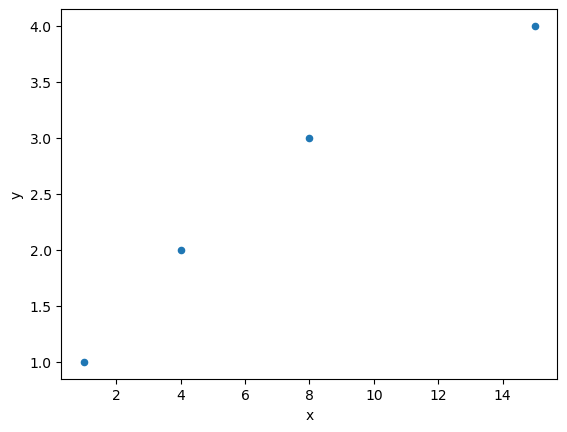

In [ ]:
X = [1, 4, 8, 15]
y = [1, 2, 3, 4]

plot_ex2(X, y)  # see in above how this is plotted

In matrix form, the data is (data found in the code):
 
$ X = \begin{pmatrix}
1 & 1 \\ 
1 & 4 \\
1 & 8 \\
1 & 15 \\
\end{pmatrix} $
$\qquad Y = \begin{pmatrix} 1 \\ 2 \\ 3 \\ 4 \end{pmatrix}$
$ \qquad X^T = \begin{pmatrix} 1 & 1 & 1 & 1  \\ 1 & 4 & 8 & 15\end{pmatrix} $
 
We previously found the formula: $\theta^* = (\boldsymbol{X^TX})^{-1}\boldsymbol{X^T}y$

$(\boldsymbol{X^TX})^{-1}= \begin{pmatrix}
\frac{153}{220} & \frac{-7}{110} \\ 
\frac{-7}{110} & \frac{1}{110}\\
\end{pmatrix} $

$(\boldsymbol{X^T})y =\begin{pmatrix}
10 \\ 
93\\
\end{pmatrix} $   Hence:

$(\boldsymbol{X^TX})^{-1}\boldsymbol{X^T}y= \begin{pmatrix}
\frac{153}{220} & \frac{-7}{110} \\ 
\frac{-7}{110} & \frac{1}{110}\\
\end{pmatrix} * \begin{pmatrix}
10 \\ 
93\\
\end{pmatrix} = \begin{pmatrix}
\frac{57}{55}\\ 
\frac{23}{100}\\
\end{pmatrix} =\theta^* $


#### Question 2

Check graphically that the model you obtained fits the data well using the following cell (uncomment and complete the first two lines and uncomment the last one).

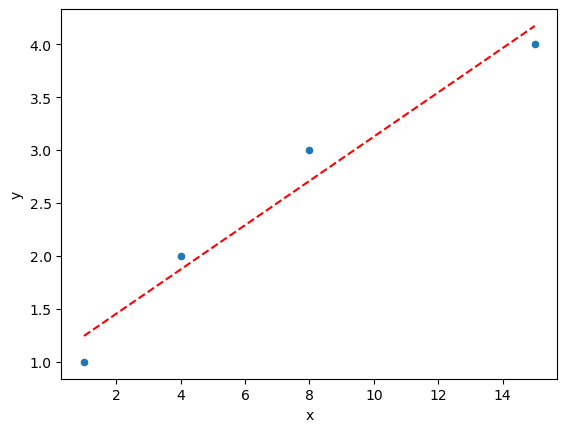

In [ ]:
theta_0 =  57/55  # <- TO UNCOMMENT AND TO COMPLETE (intercept)
theta_1 = 23/110  # <- TO UNCOMMENT AND TO COMPLETE (slope)

# YOUR CODE HERE

plot_ex2(X, y, theta_0, theta_1)  # see above how this is plotted

#### Question 3

Plot the MSE $E(\boldsymbol{\theta})$ with the following cells.
What is plotted? What is the input space and the output space?

What can you say about these plots?

In [ ]:
X = np.array([[1, 1, 1, 1], X]).T
y = np.array(y).reshape(-1, 1)

In [ ]:
class MSE:
    def __init__(self, X, y):
        self.X = np.copy(X)
        self.y = np.copy(y)
        
    def __call__(self, theta):
        return ((np.tile(self.y, theta.shape[1]) - np.dot(self.X, theta))**2).sum(axis=0)
    
mse = MSE(X, y)

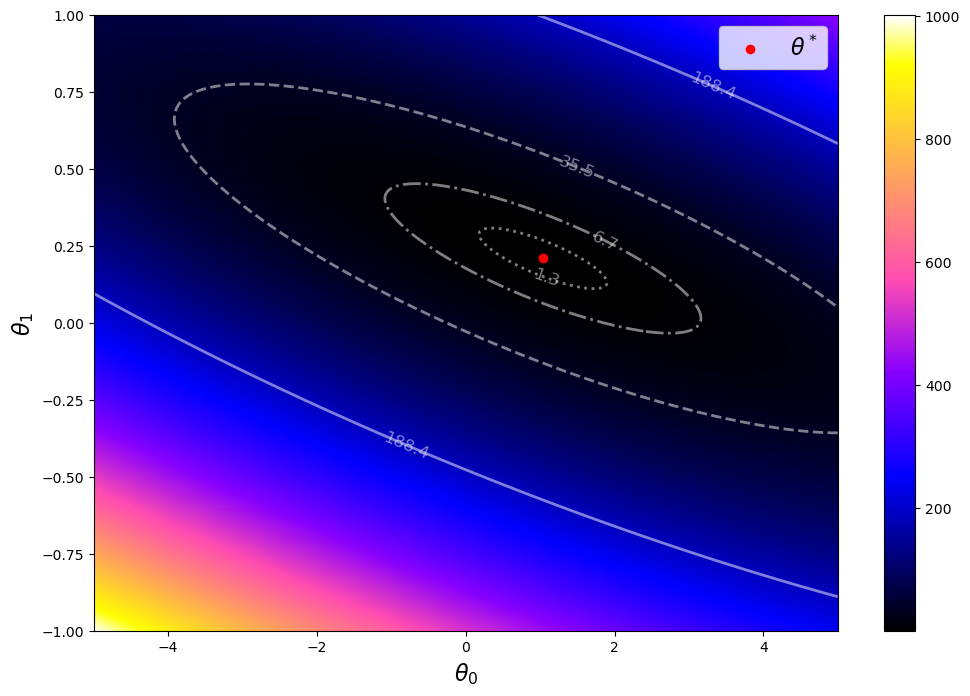

In [ ]:
# see above how this is plotted
plot_contour_2d_solution_space(mse,
                               theta_min=np.array([-5, -1]),
                               theta_max=np.array([5, 1]),
                               theta_star=np.array([[theta_0], [theta_1]]));

The graph shows how E(${\theta}$) changes with a change in ${\theta_0}$ and ${\theta_1}$. The coloured column on the right gives us the values of E(${\theta}$) associated to each colour. As we can see, the error is the lowest when the ${\theta}$ vectors are in the black area. The plot confirms that the minimal error is obtained for ${\theta}^*$ = $\begin{pmatrix} \theta_0 \\ \theta_1 \end{pmatrix} $ = $\begin{pmatrix} 57/55 \\ 23/100 \end{pmatrix} \approx \begin{pmatrix} 1.03 \\ 0.23 \end{pmatrix} $

## Linear regression: an approximated solution using a *gradient descent* method

When $(X^TX)^{-1}$ cannot be easily computed (e.g. no analytical solution or $\mathcal{D}$ contains a lot of examples or the dimension of the solution space $\mathcal{X}$ is too large), an approximated solution can be computed using a *gradient descent method*.

Also, we'll use *gradient descent* for other models than linear regression, so this will serve as an introduction.

$\nabla_{\theta}E(\hat{\theta})$ gives the direction of the largest slope at the point $\hat{\theta}$.
Thus, if we explore iteratively the parameter space by following the opposite direction of this gradient as described in the following definition, we should converge to the parameter $\boldsymbol{\theta}^\star$ that minimizes the MSE, i.e. the parameter $\theta^\star$ such that $\nabla_{\theta^\star}E({\theta^\star}) = 0$.

Starting from a random point $\boldsymbol{\theta}$, the gradient descent method proposes a new point 
$\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \eta \nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta})$ at each iteration until a stopping criterion has been reached: e.g. $||\nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta})||_2^2 > \epsilon_{\delta}$ with $\epsilon_{\delta}$ a chosen minimal length for the gradient to continue iterations.

The *learning rate* $\eta \in \mathbb{R}_+^*$ is a parameter to tweak for the considered problem.
- If $\eta$ is too large, the optimization may not converge toward 0.
- If $\eta$ is too small, the optimization may require a lot of iterations to converge.

### Exercise 3

#### Question 1

In our one-dimensional example of four points, calculate the expression of the gradient.

We previously computed $\nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta})= -2X^Ty + 2(X^TX)\theta$

Here, $ X = \begin{pmatrix}
1 & 1 \\ 
1 & 4 \\
1 & 8 \\
1 & 15 \\
\end{pmatrix} $
$\qquad Y = \begin{pmatrix} 1 \\ 2 \\ 3 \\ 4 \end{pmatrix}$
$ \qquad X^T = \begin{pmatrix} 1 & 1 & 1 & 1  \\ 1 & 4 & 8 & 15\end{pmatrix} $
$ \qquad \theta = \begin{pmatrix} \theta_0  \\ \theta_1 \end{pmatrix} $
$\qquad-2(\boldsymbol{X^T})y =\begin{pmatrix}
-20 \\ 
-186\\
\end{pmatrix} $ 
$ \qquad 2(X^TX) = \begin{pmatrix} 8 & 56  \\ 56 & 612\end{pmatrix} $

Hence
$\nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta})= -2X^Ty + 2(X^TX)\theta =\begin{pmatrix}
-20 \\ 
-186\\\end{pmatrix} + \begin{pmatrix} 8 & 56  \\ 56 & 612\end{pmatrix}* \begin{pmatrix} \theta_0  \\ \theta_1 \end{pmatrix} = \begin{pmatrix} 8 \theta_0 +56\theta_1 -20  \\56\theta_0 + 612\theta_1 -186\end{pmatrix} $

Implement a gradient descent method to solve exercise 2 with an approximated solution.
Use the analytic formulation of $\nabla_{\boldsymbol{\theta}}E(\boldsymbol{\theta})$ that has been computed in exercise 1.

You can use a very basic stopping criterion: the number of iterations (e.g. 10000).
You can start with $\eta = 0.001$.

In [ ]:
def gradient_descent(X, y, eta=0.001, max_iteration=10000, 
                     theta=np.random.normal(loc=0, scale=10, size=[2, 1])):

    # Perform useful matrix multiplication
    # YOUR CODE HERE
    Xty = -2 * np.matmul(np.transpose(X), y)
    XtX = -2 * np.matmul(np.transpose(X), X)

    grad_list = []      # Keep the gradient of all iterations
    theta_list = []     # Keep the solution of all iterations

    for i in range(max_iteration):
        # Perform the gradient descent here
        grad = Xty -np.matmul(XtX, theta)
        theta = theta- eta * grad

        # YOUR CODE HERE

        grad_list.append([grad[0][0], grad[1][0]])      # Keep the gradient
        theta_list.append([theta[0][0], theta[1][0]])   # Keep the solution

    return grad_list, theta_list

In [ ]:
grad_list, theta_list = gradient_descent(X, y)

dataframe_grad = pd.DataFrame(grad_list, columns=["grad1", "grad2"])
dataframe_theta = pd.DataFrame(theta_list, columns=["theta1", "theta2"])

dataframe_theta.tail()  # Display the last lines and observe convergence to what you found analytically

,theta1,theta2
9995,1.036364,0.209091
9996,1.036364,0.209091
9997,1.036364,0.209091
9998,1.036364,0.209091
9999,1.036364,0.209091


#### Question 2

Print or plot the value of $\theta$ and $E(\theta)$ obtained at each iteration.
Check that $E(\theta)$ converges to 0 and that $\theta$ converges to the solution obtained in exercise 2.

You can make use of `df_theta` as provided in the previous cell.

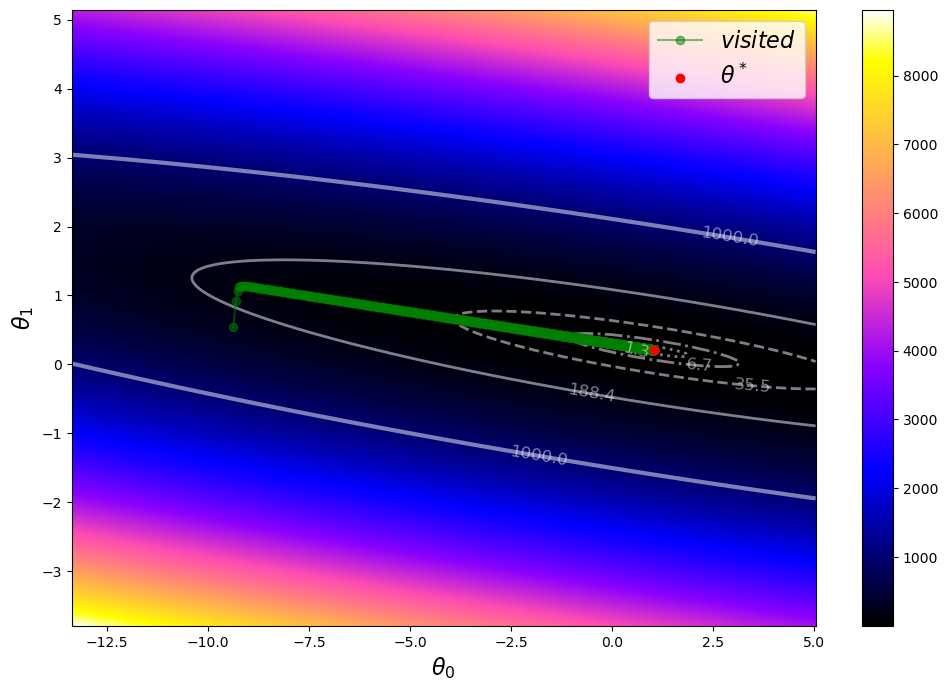

In [ ]:
theta_min = dataframe_theta.min().values
theta_max = dataframe_theta.max().values
theta_visited = dataframe_theta.values # numpy array of values of theta obtained through gradient descent (be careful about the expected shape)

# YOUR CODE HERE
# see above how this is plotted
plot_contour_2d_solution_space(mse,
                               theta_min - 2.,
                               theta_max=theta_max + 2.,
                               theta_visited=theta_visited,
                               theta_star=np.array([[theta_0], [theta_1]]));

#### Question 3

Print or plot the norm of the gradient. You can make use of `dataframe_grad` provided earlier. How do you interpret it?

In [ ]:
def plot_gradient(df_gradient: pd.DataFrame):
    df = df_gradient.copy()  # make an alias
    # Put the norm of the gradient at each iteration in a column named "norm"
    df['norm'] = np.sqrt(dataframe_grad['grad1']**2 + dataframe_grad['grad2']**2)

    # YOUR CODE HERE

    ax = df.norm.plot(loglog=True, figsize=(16, 8))

    ax.set_title(r"Evolution of $||\nabla_{\theta} E(\theta)||_2$", fontsize=16)
    ax.set_xlabel("Iteration number", fontsize=16)
    ax.set_ylabel(r"Norm of $\nabla_{\theta} E(\theta)$", fontsize=16);

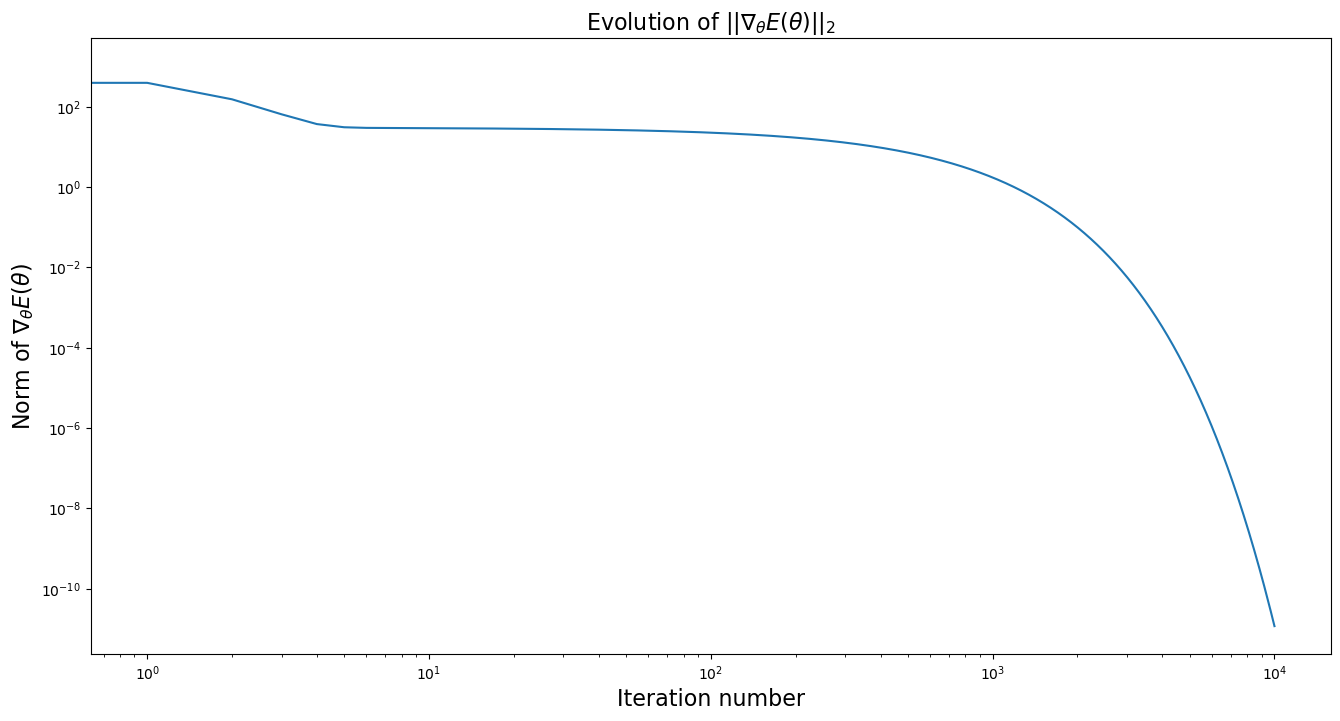

In [ ]:
plot_gradient(dataframe_grad)

We can notice a sudden drop in the norm of the gradient after $10^3$ iterations.The norm of the gradient of the error is a measure of the rate of change of the error with respect to $\theta$. A large norm indicates that the error is changing rapidly, while a small norm indicates that the error is changing slowly. Therefore, the sudden drop that we observe demonstrates that our model has reached a point where the error is changing very slowly with respect to $\theta$ and is thus reaching an optimal solution.

#### Question 4

Restart the optimization using a different *learning rate* $\eta$. What do you observe?

As we can observe, if $\eta$ is very small, it converges very slowly to the optimal solution.

In [ ]:
# Try with different values of eta (and optionally theta) IN SEPARATE CODE CELLS
def display_theta_visited_norm(eta=0.000001, theta=np.array([[7],[2]]), max_iteration=10000):
    grad_list, theta_list = gradient_descent(X, y, eta, max_iteration, theta)
    # YOUR CODE HERE

    # Use the same procedure as previously:
    df_grad = pd.DataFrame(grad_list, columns=["grad1", "grad2"])
    df_theta = pd.DataFrame(theta_list, columns=["theta1", "theta2"])
    theta_min = df_theta.min().values
    theta_max = df_theta.max().values
    theta_visited = df_theta.values

    # YOUR CODE HERE

    # see above how this is plotted
    plot_contour_2d_solution_space(mse,
                                   theta_min=theta_min - 2.,
                                   theta_max=theta_max + 2.,
                                   theta_visited=theta_visited,
                                   theta_star=np.array([[theta_0], [theta_1]]));

    # Computing the norm
    plot_gradient(df_grad)

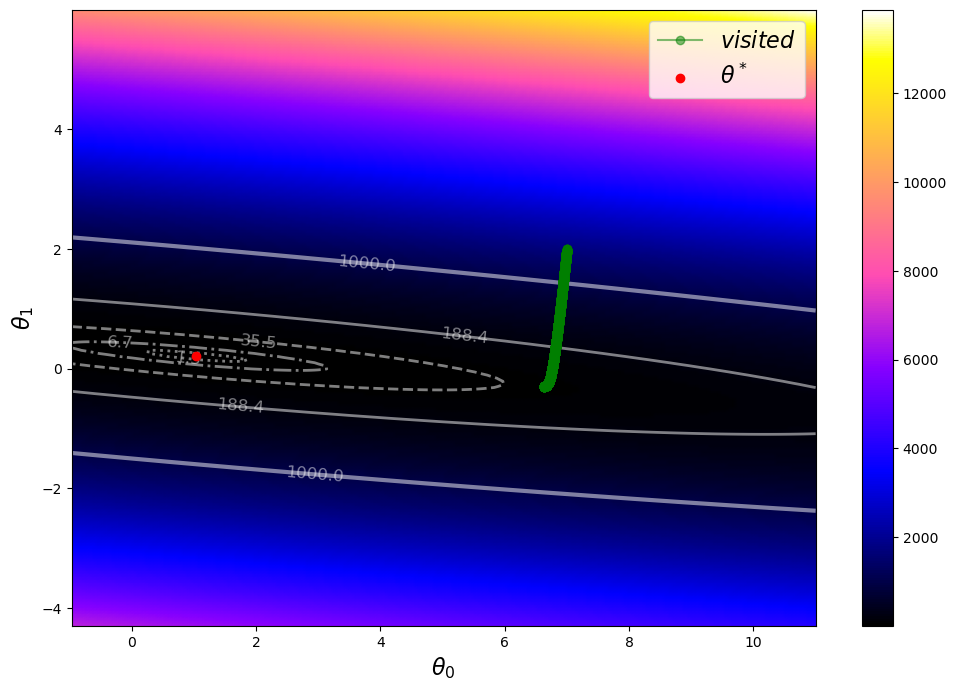

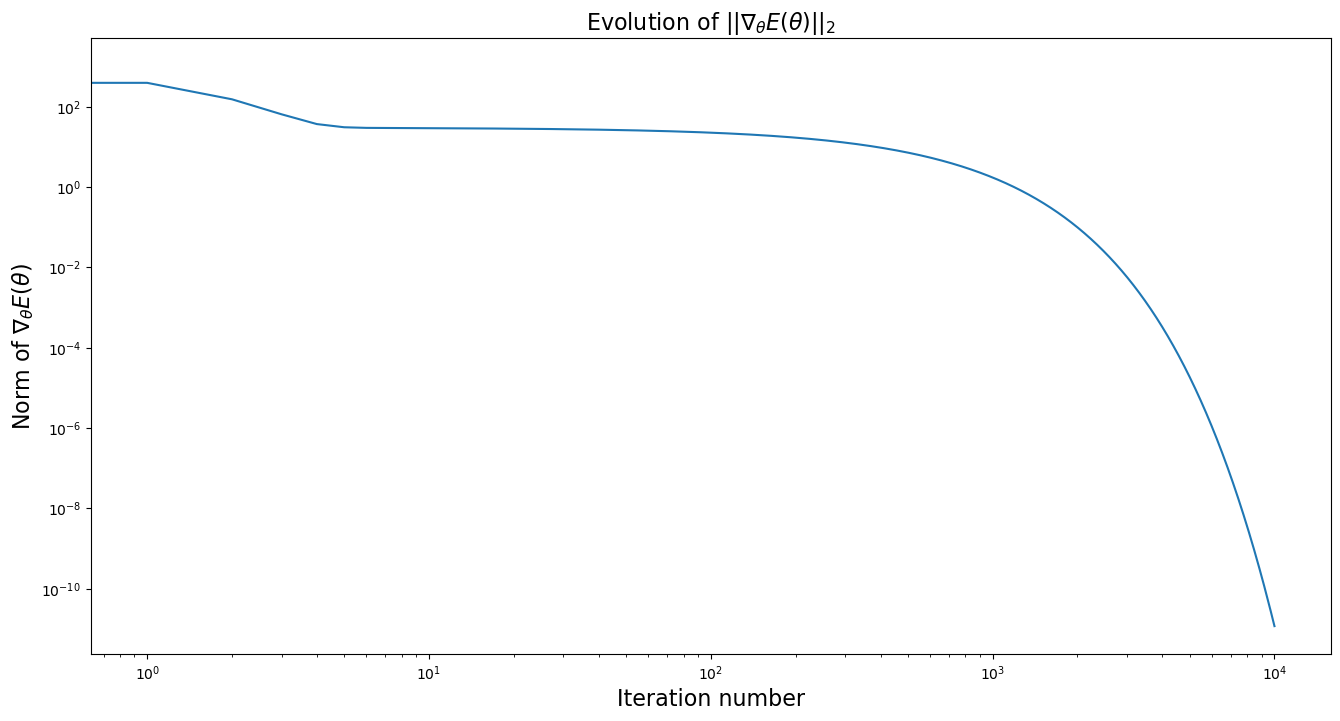

In [ ]:
display_theta_visited_norm()
# YOUR CODE HERE


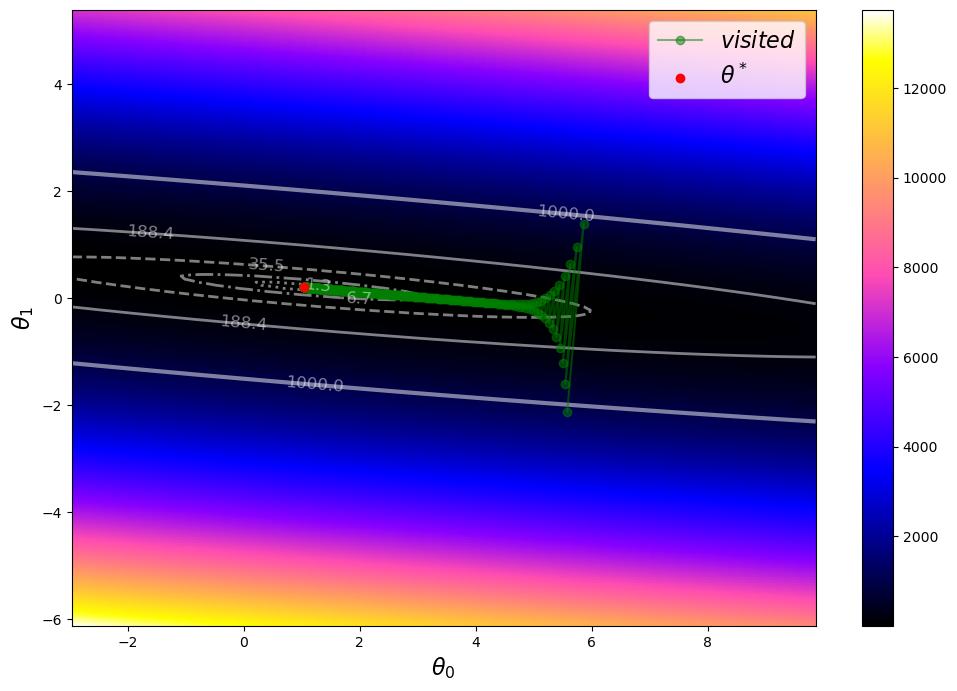

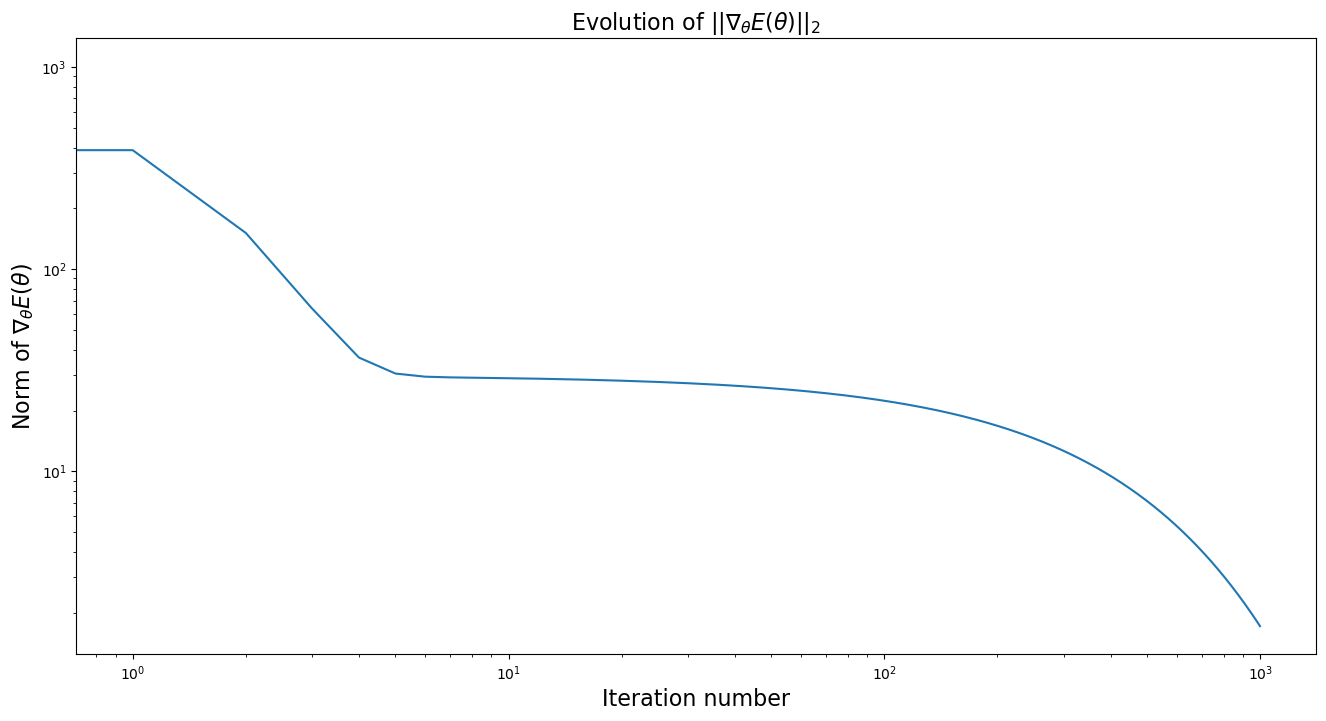

In [ ]:
display_theta_visited_norm(eta=0.003, theta=np.array([[6],[2]]), max_iteration=1000)

As we can see, if $\eta$ is increased, the model oscillates, but eventually converges to the optimal solution.

/tmp/ipykernel_65/3637285342.py:144: UserWarning: No contour levels were found within the data range.
  cs = plt.contour(x1_mesh,


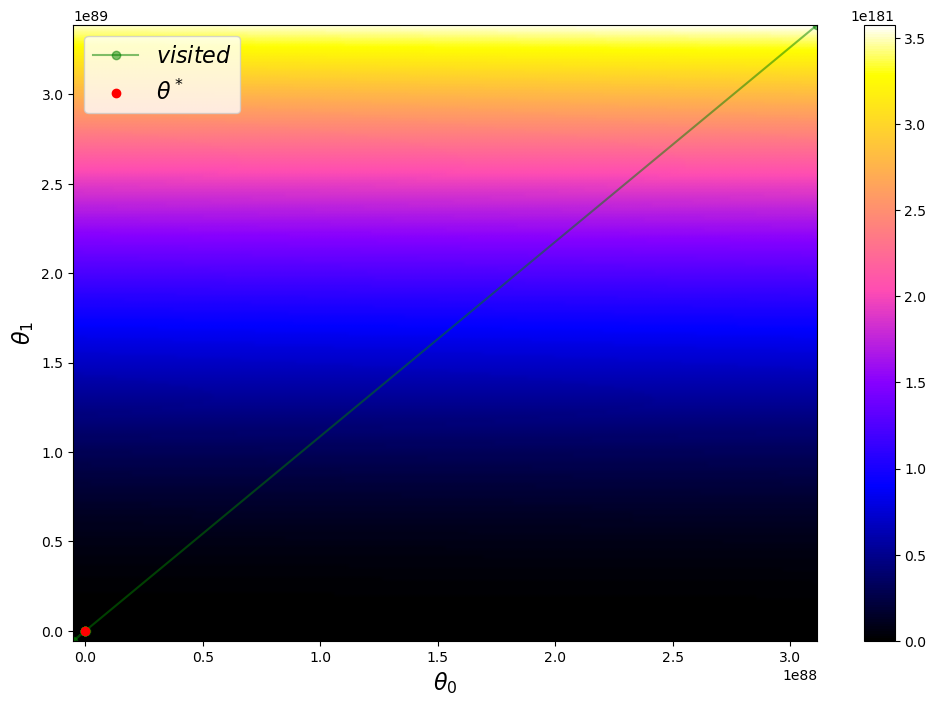

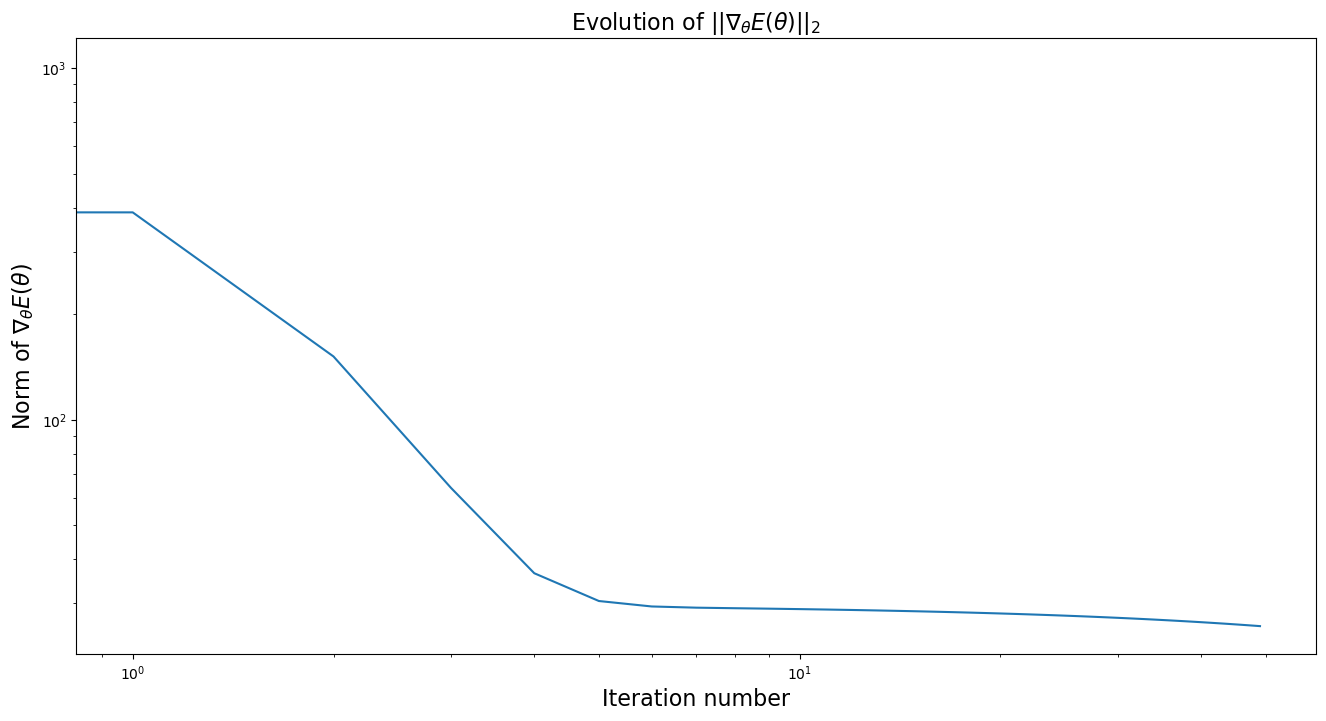

In [ ]:
display_theta_visited_norm(eta=0.1,theta=np.array([[7],[2]]), max_iteration=50)

If $\eta$ is large, the curve goes to infinity and we get an overflow error because the error term becomes too large.

## Linear regression with Scikit Learn

Let's play with the Scikit Learn implementation of linear regression.
The official documentation is there: https://scikit-learn.org/stable/modules/linear_model.html

Use the `gen_1d_linear_regression_samples()` function (defined above) to generate a dataset and `plot_1d_regression_samples()` to plot it.

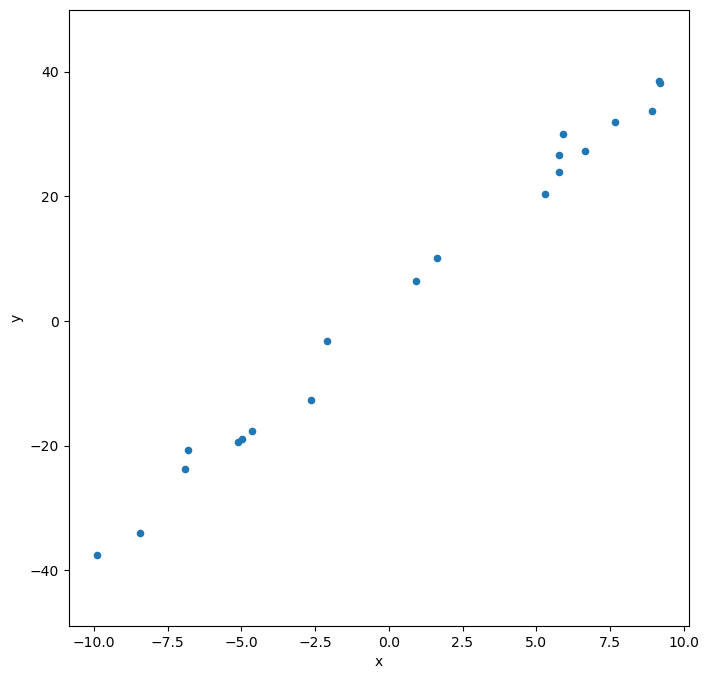

In [ ]:
df = gen_1d_linear_regression_samples()

plot_1d_regression_samples(df)

Once the dataset is ready, let's make the regressor and train it with the following code:

In [ ]:
linear_model = sklearn.linear_model.LinearRegression()

linear_model.fit(df[['x']], df[['y']])

LinearRegression()

The following cell plots the learned model (the red dashed line) and the dataset $\mathcal{D}$ (blue points).

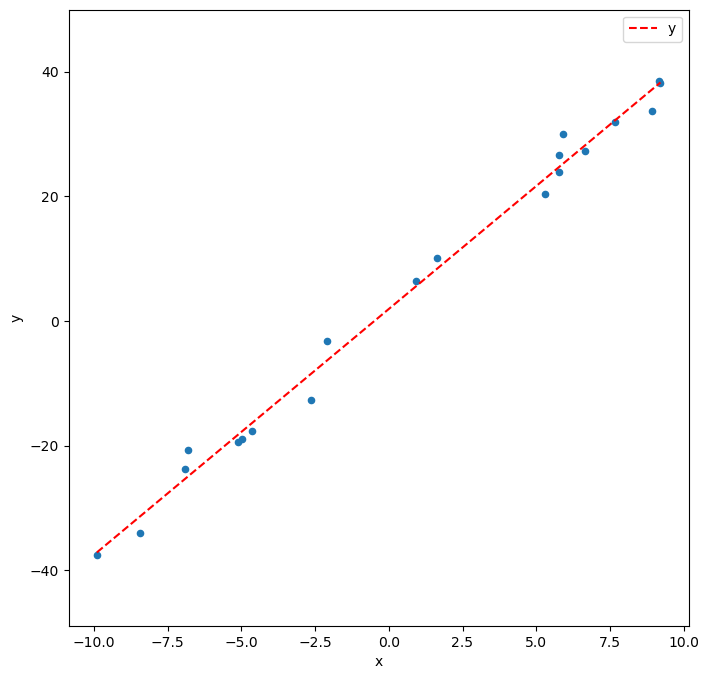

In [ ]:
plot_1d_regression_samples(df, model=linear_model)

### Exercise 4

#### Question 1

What are the optimal parameters $\theta_1$ (intercept) and $\theta_2$ obtained? Put them in `intercept` and `slope`.
(Note: there are attributes to the `LinearRegression` class which provide them)

In [ ]:
intercept = linear_model.intercept_[0]
slope = linear_model.coef_[0][0]
print(f'intercept = {intercept} \nslope= {slope}')
# YOUR CODE HERE

intercept = 1.9150452341883528 
slope= 3.9449740841116117


#### Question 2

Write the mathematical definition of the generated data (see above) and your model.

Implement both as a function of X and plot it.

$f(X)=4X+2+\epsilon$, $\epsilon$ being the error term


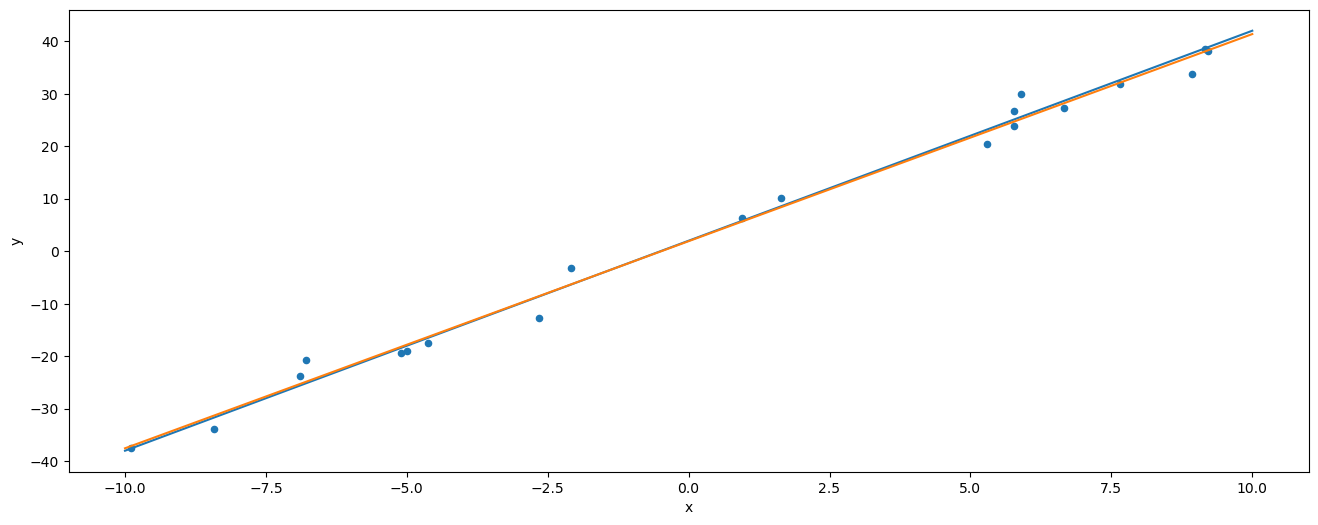

In [ ]:
def f(X):
    return 4*X+2
    

def f_hat(X):
    # YOUR CODE HERE
    return slope*X + intercept

ax = df.plot.scatter(x='x', y='y', figsize=(16, 6))

X = np.array([-10, 10])
ax.plot(X, f(X))
ax.plot(X, f_hat(X));

#### Question 3

Use the `model.predict()` function to guess the class of the following points in a *vectorized* way (i.e. applying the `predict` method on an array, and returning and an array); put the result in `linear_predictions`:

$$x_{p1} = -2, \quad x_{p2} = 2, \quad x_{p3} = 6$$

In [ ]:
predictions = linear_model.predict(np.array([[-2], [2], [6]]))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Polynomial regression

It is a common practice to use linear models trained on nonlinear transformations of the input data in machine learning. This approach maintains the generally fast performance of linear methods, while allowing them to fit a much wider range of data.

For instance, a linear model can be extended by making polynomial features from the coefficients. Linear model in exercises 1 and 2 looks like this (one-dimensional data):

$$f_{\theta}(x) = \theta_0 + \theta_1 x$$

If we want to fit a quadratic curve to the data instead of a line, we can combine the features in second-order polynomials, so that the model looks like this:

$$f_{\theta}(x) = \theta_0 + \theta_1 x + \theta_2 x^2$$

This is still a linear model: to illustrate this, we can create a new variable

$$z = [x, x^2]$$

With this re-labeling of the data, our problem can be written

$$f_{\theta}(x) = \theta_0 + \theta_1 z_1 + \theta_2 z_2$$

The resulting polynomial regression is in the same class of linear models we'd considered above (i.e. the model is linear in $\theta$) and can be solved by the same techniques. Thus the linear model has the flexibility to fit a much broader range of data.

### Exercise 5

#### Question 1

Use the previous equations to compute **by hand** (i.e. on a sheet of paper) the optimal parameters $\theta_1$ and $\theta_2$ of the model $y = \theta_1 x + \theta_1 x^2$ to best fit the following dataset (of four examples):

$$\mathcal{D} = \left\{
\begin{pmatrix} 1 \\ 0 \end{pmatrix},
\begin{pmatrix} 2 \\ 2 \end{pmatrix},
\begin{pmatrix} 3 \\ 3 \end{pmatrix},
\begin{pmatrix} 4 \\ 3.5 \end{pmatrix},
\begin{pmatrix} 5 \\ 3.7 \end{pmatrix}
\right\}.$$

In matrix form, the data is:
 
$ X = \begin{pmatrix}
1 & 1 \\ 
2 & 4 \\
3 & 9 \\
4 & 16 \\
5 & 25 \\
\end{pmatrix} $
$\qquad Y = \begin{pmatrix} 0 \\ 2 \\ 3 \\ 3.5 \\3.7 \end{pmatrix}$
$ \qquad X^T = \begin{pmatrix} 1 & 2 & 3 & 4 & 5 \\ 1 & 4 & 9 & 16& 25\end{pmatrix} $
$ \qquad \theta = \begin{pmatrix} \theta_1  \\ \theta_2 \end{pmatrix} $
 
Using: $\theta^* = (\boldsymbol{X^TX})^{-1}\boldsymbol{X^T}y$

$(\boldsymbol{X^TX})^{-1}= \begin{pmatrix}
\frac{979}{3220} & \frac{-45}{644} \\
\frac{-45}{644} & \frac{11}{644}
\end{pmatrix} $


$(\boldsymbol{X^T})y =\begin{pmatrix}
\frac{91}{2} \\
\frac{367}{2}
\end{pmatrix} $   Hence:

$(\boldsymbol{X^TX})^{-1}\boldsymbol{X^T}y=  \begin{pmatrix}
\frac{979}{3220} & \frac{-45}{644} \\
\frac{-45}{644} & \frac{11}{644}
\end{pmatrix} * \begin{pmatrix}
\frac{91}{2} \\
\frac{367}{2}
\end{pmatrix} = \begin{pmatrix}
\frac{3257}{3220} \\
\frac{-29}{644}
\end{pmatrix} =\theta^*$

Thus, $\theta^* = \begin{pmatrix}
\frac{3257}{3220} \\
\frac{-29}{644}
\end{pmatrix} \approx \begin{pmatrix}
1.01149068323\\
-0.0450310559
\end{pmatrix}$

Therefore, the equation of the model gives: $y=1.01x-0.05x^2$


You can (optionnally) check your results using `numpy`. See e.g. `@`, `np.dot`, `np.matmul` and `np.linalg.inv`.

In [ ]:
# YOUR CODE HERE
X = np.array([[1, 2, 3, 4, 5],[1, 4, 9, 16, 25]]).T
y = np.array([0, 2, 3, 3.5, 3.7])
XX = np.dot(X.T, X)
print(XX)
Xy = np.dot(X.T, y)
print(Xy)
invXX = np.linalg.inv(XX)
print(invXX)
np.dot(invXX, Xy)

[[ 55 225]
 [225 979]]
[ 45.5 183.5]
[[ 0.30403727 -0.06987578]
 [-0.06987578  0.01708075]]


array([ 1.01149068, -0.04503106])

Let's plot these points:

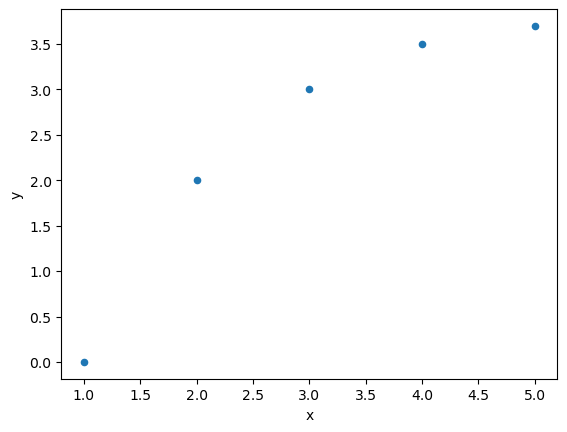

In [ ]:
X = [1, 2, 3, 4, 5]
y = [0, 2, 3, 3.5, 3.7]

plot_ex4(X, y)

#### Question 2

Check graphically that the model you obtained fits the data well using the following cell (complete the first two lines).

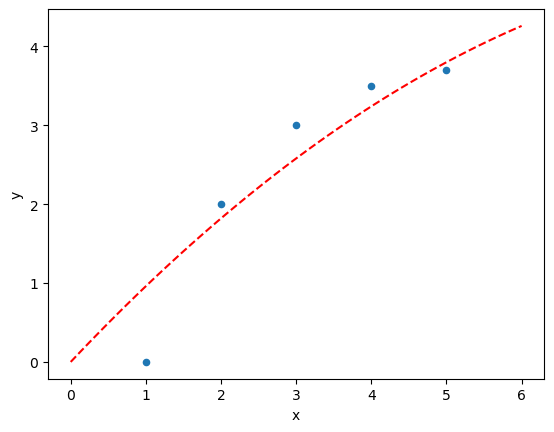

In [ ]:
X = [1, 2, 3, 4, 5]
y = [0, 2, 3, 3.5, 3.7]

theta_1 = 1.01  # <- TO UNCOMMENT
theta_2 = -0.05  # <- TO UNCOMMENT
# YOUR CODE HERE

plot_ex4(X, y, theta_1, theta_2)

This doesn't seem very good: why?

In our model here, we omitted the error term, which leads to some inaccuracies. Moreover, the coefficients were rounded and not used in their fraction form, which gives more errors. As we can see, the point (1,0) is not close to the curve.

## Polynomial regression with Scikit Learn

Let's play with the Scikit Learn implementation of polynomial regression.
The official documentation is there: https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions

First we generate the dataset, plot it, instantiate a regressor and train it with the following code:

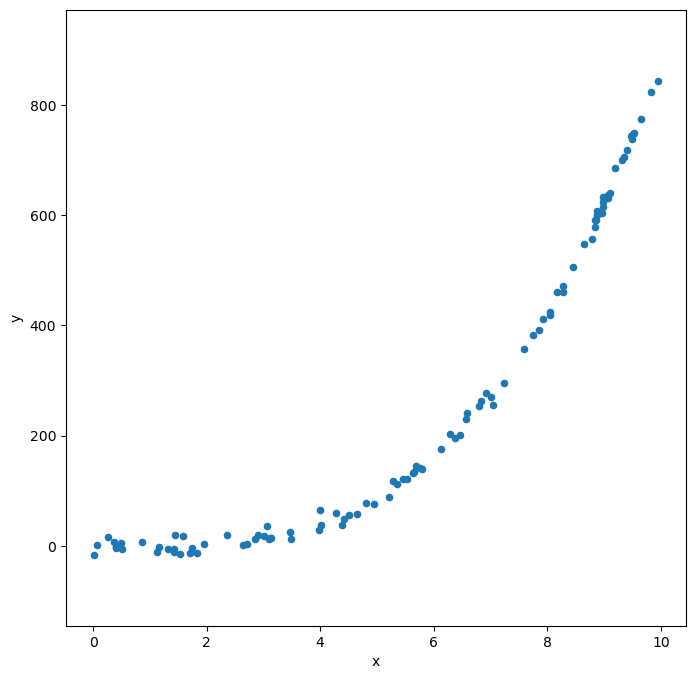

In [ ]:
df = gen_1d_polynomial_regression_samples(n_samples=100)
plot_1d_regression_samples(df)

In [ ]:
polynomial_features = sklearn.preprocessing.PolynomialFeatures(degree=3)  # In Q. 4, try with degree = 1, 4 and 15

In `sklearn.preprocessing.PolynomialFeatures()`, `degree` is the degree of the polynomal function.

In [ ]:
def learn_poly_model(poly_features: sklearn.preprocessing.PolynomialFeatures):
    # no intercept in the LinearRegression since PolynomialFeatures includes a "bias"
    # see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
    linear_regression = sklearn.linear_model.LinearRegression(fit_intercept=False)

    model = sklearn.pipeline.Pipeline([("polynomial_features", polynomial_features),
                                       ("linear_regression", linear_regression)])

    model.fit(df[['x']], df[['y']])
    return linear_regression, model

In [ ]:
linear_regression, model = learn_poly_model(polynomial_features)

The following cell plots the learned model (the red dashed line) and the dataset $\mathcal{D}$ (blue points).

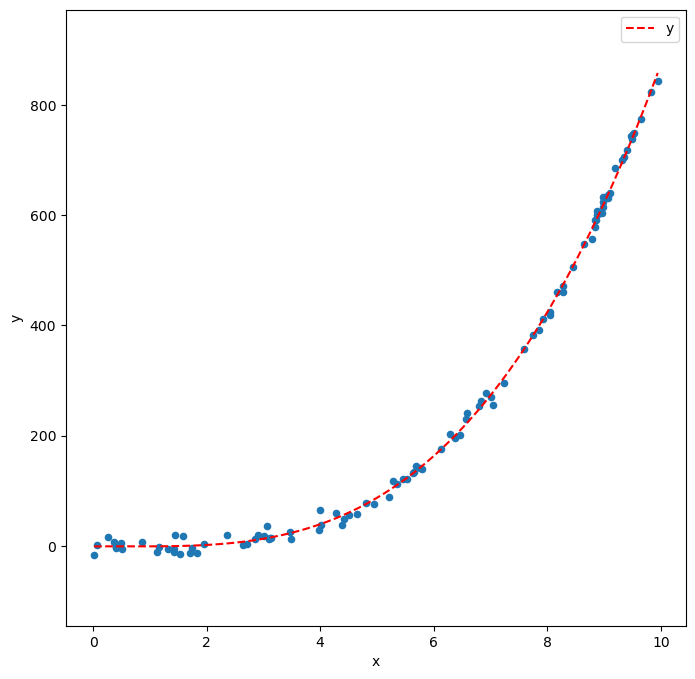

In [ ]:
plot_1d_regression_samples(df, model=model)

### Exercise 6

#### Question 1

What are the optimal parameters $\theta_0, \theta_1, \theta_2, \theta_3$ obtained? Check the attributes of `linear_regression`. Remember from above that a bias term (1) is included in the PolynomialFeatures but we did not allow (which would be redundant) LinearRegression to fit an intercept term.

In [ ]:
theta_0 = linear_regression.coef_[0, 0]
theta_1 = linear_regression.coef_[0, 1]
theta_2 = linear_regression.coef_[0, 2]
theta_3 = linear_regression.coef_[0, 3]

print("theta0: ", theta_0, 
        "\ntheta1: ", theta_1, 
        "\ntheta2: ", theta_2, 
        "\ntheta3: ", theta_3, 
)

theta0:  -1.1707675929261607 
theta1:  1.1330207034810469 
theta2:  -2.0181613331859363 
theta3:  1.065004529853835


#### Question 2

Write the mathematical definition of the generated data (see above) and your model. Plot the result.

$f(X)=X^3-0.5X^2-3.1X-2$

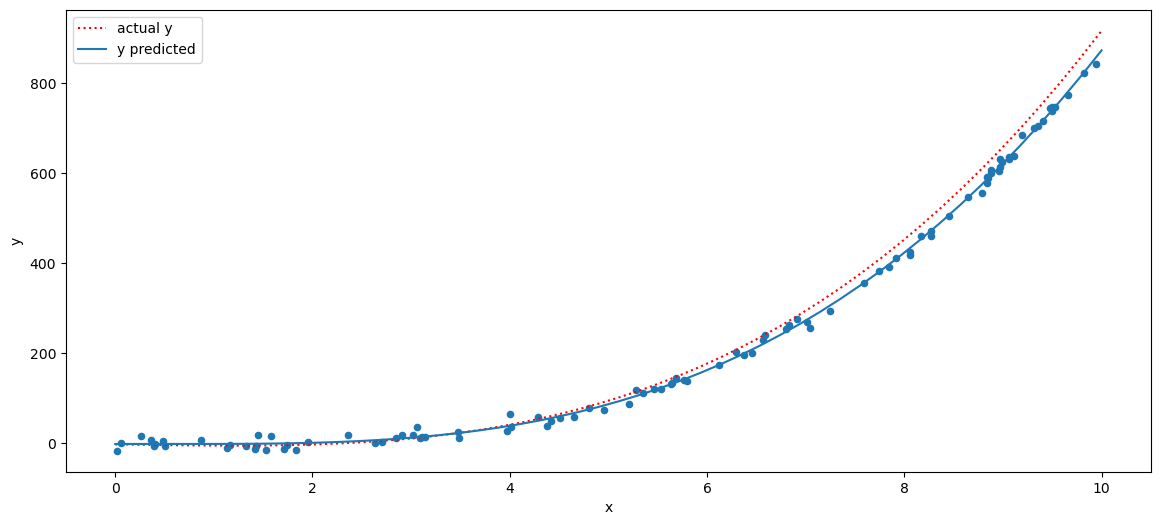

In [ ]:
x = np.linspace(0., 10., 50)

y_hat = theta_0+theta_1*x+theta_2*(x**2)+theta_3*(x**3)  # <- TO UNCOMMENT: this is sklearn's prediction
y = -2-3.1*x-0.5*(x**2)+x**3  # <- TO UNCOMMENT: this is the equation you found by looking above

# YOUR CODE HERE

ax = df.plot.scatter(x='x', y='y', figsize=(14, 6))

df_model = pd.DataFrame(np.array([x, y, y_hat]).T, columns=['x', 'y', 'y_pred'])

df_model.plot(x='x', y='y', style=':r', label='actual y', ax=ax)
df_model.plot(x='x', y='y_pred', label='y predicted', ax=ax);

#### Question 3

Use the `model.predict()` function to infer the `y` value of the following points:

$$x_{p1} = 1, \quad x_{p2} = 2, \quad x_{p3} = 6$$

Put the result in `predictions`.

In [ ]:
predictions =  model.predict([[1], [2], [6]])


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


#### Question 4

In `sklearn.preprocessing.PolynomialFeatures()`, change the value of `degree` and describe what happen on the plot (use e.g. 1 and 15 - possibly with fewer observations).
What is the name of the observed phenomenons?

We can see that with degree 1, the line underfits our data.

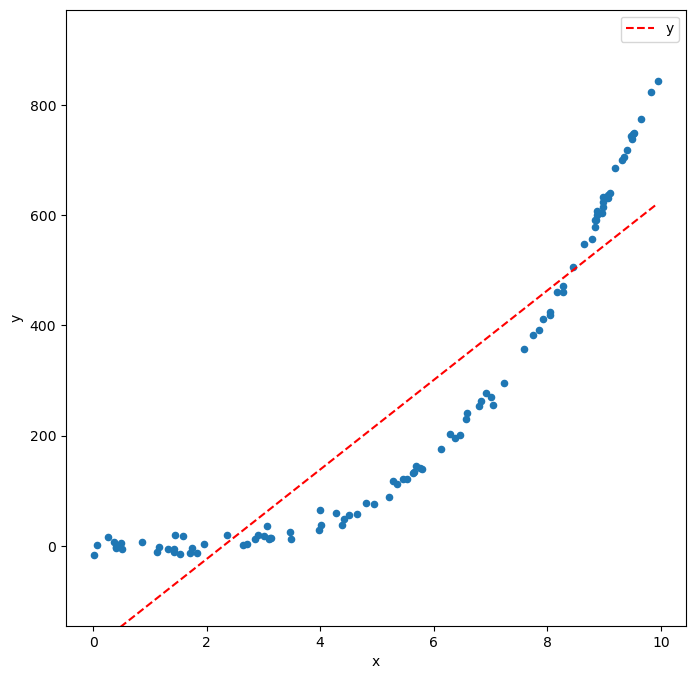

In [ ]:
polynomial_features = sklearn.preprocessing.PolynomialFeatures(degree=1) # TO UNCOMMENT, use e.g. degree 1

# YOUR CODE HERE

linear_regression, model = learn_poly_model(polynomial_features)

plot_1d_regression_samples(df, model=model)

However, when we have degree 15, the curve overfits our data. This means that the algorithm will perform very well on the training data, but very poorly on new inputs because it thinks it knows a certain pattern about how the data is, but this pattern might not work on additional data because the model used the noise of the training to find this pattern.

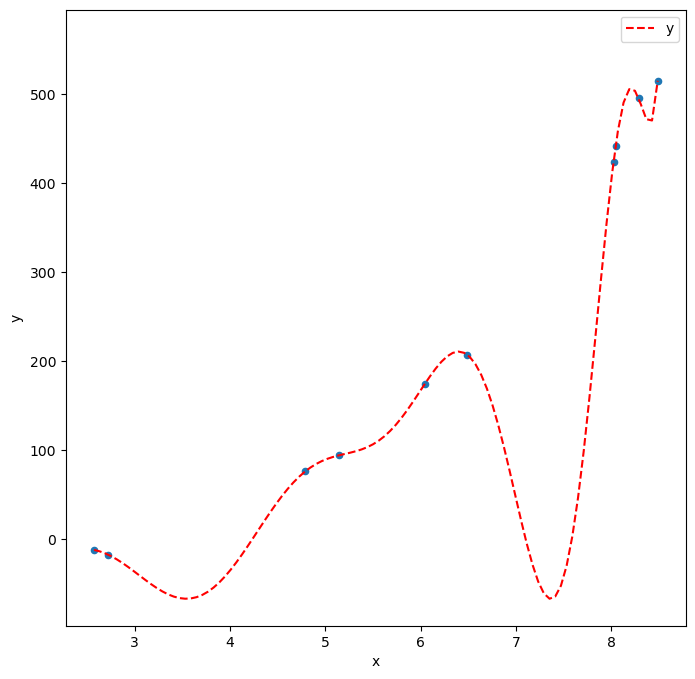

In [ ]:
df = gen_1d_polynomial_regression_samples(n_samples=10)

polynomial_features = sklearn.preprocessing.PolynomialFeatures(degree=15)  # TO UNCOMMENT, use e.g. degree 15

# YOUR CODE HERE

linear_regression, model = learn_poly_model(polynomial_features)

plot_1d_regression_samples(df, model=model)

## CO2 Emission Forecast (bonus)

In this exercise, you will forecast 5 years of future CO2 emission from power generation using natural gas.

This exercise use a dataset taken from https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima.

This public dataset contain monthly carbon dioxide emissions from electricity generation. The dataset includes CO2 emissions starting January 1973 to July 2016.

In [ ]:
filepath = "~/shareddata/CSE204/natural_gas_co2_emissions_for_electric_power_sector.csv"

df = pd.read_csv(filepath,
                 parse_dates=[0])
df.head()

NameError: name 'pd' is not defined

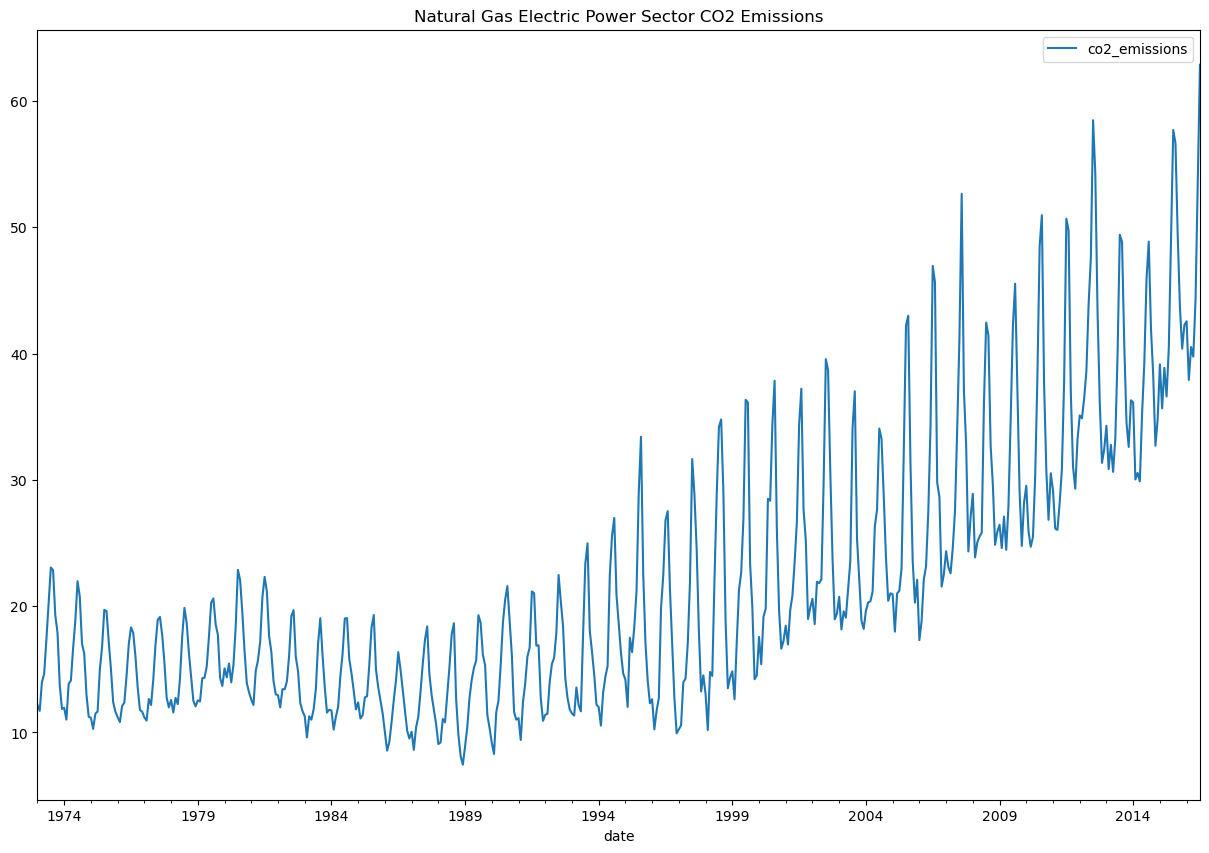

In [ ]:
df.plot(x='date', y='co2_emissions', figsize=(15,10), title='Natural Gas Electric Power Sector CO2 Emissions');

### Exercise 7 (bonus)

Implement a model to make predictions on this dataset.
Use polynomial basis functions plus two sinusoids to handle the seasonality of this time series: $\sin(\frac{2 \pi}{12} x)$ and $\cos\left(\frac{2 \pi}{12} x \right)$. This signal contains a periodic component of 12 time steps (**where one time step equals to one month**).

We use both $\sin$ and $\cos$ to avoid unaligned phases with the time series. Alternatively, we could use only $\sin\left(\frac{2 \pi}{12} (x + \phi)\right)$ or $\cos\left(\frac{2 \pi}{12} (x + \phi)\right)$ as long as $\phi$ is properly set: $\phi = \pi / 2$ in the first case and $\phi = 0$ in the second one.

What are the limitations of this model?

In [ ]:
X = df.index #increments by 1 for each month, see `index` or `date`
y = df.co2_emissions # see `co2_emissions`
# Add column of 1, X², X³, ... Concatenate and create a pandas DataFrame
Z=np.array([np.ones(shape=X.shape), X, X**2,X**3,  np.sin(2. * np.pi * X / 12.), np.cos(2. * np.pi * X / 12.)]).T
# YOUR CODE HERE
df_Z = pd.DataFrame(Z, columns=['intercept', 'z', 'z2', 'z3', 'sin', 'cos'])
df_Z.tail()

,intercept,z,z2,z3,sin,cos
518,1.0,518.0,268324.0,138991832.0,8.660254e-01,5.000000e-01
519,1.0,519.0,269361.0,139798359.0,1.000000e+00,2.302769e-14
520,1.0,520.0,270400.0,140608000.0,8.660254e-01,-5.000000e-01
521,1.0,521.0,271441.0,141420761.0,5.000000e-01,-8.660254e-01
522,1.0,522.0,272484.0,142236648.0,2.841800e-14,-1.000000e+00


With the following plot, we check that the seasonality of the time series is correctly aligned with our sine and cosine bases:

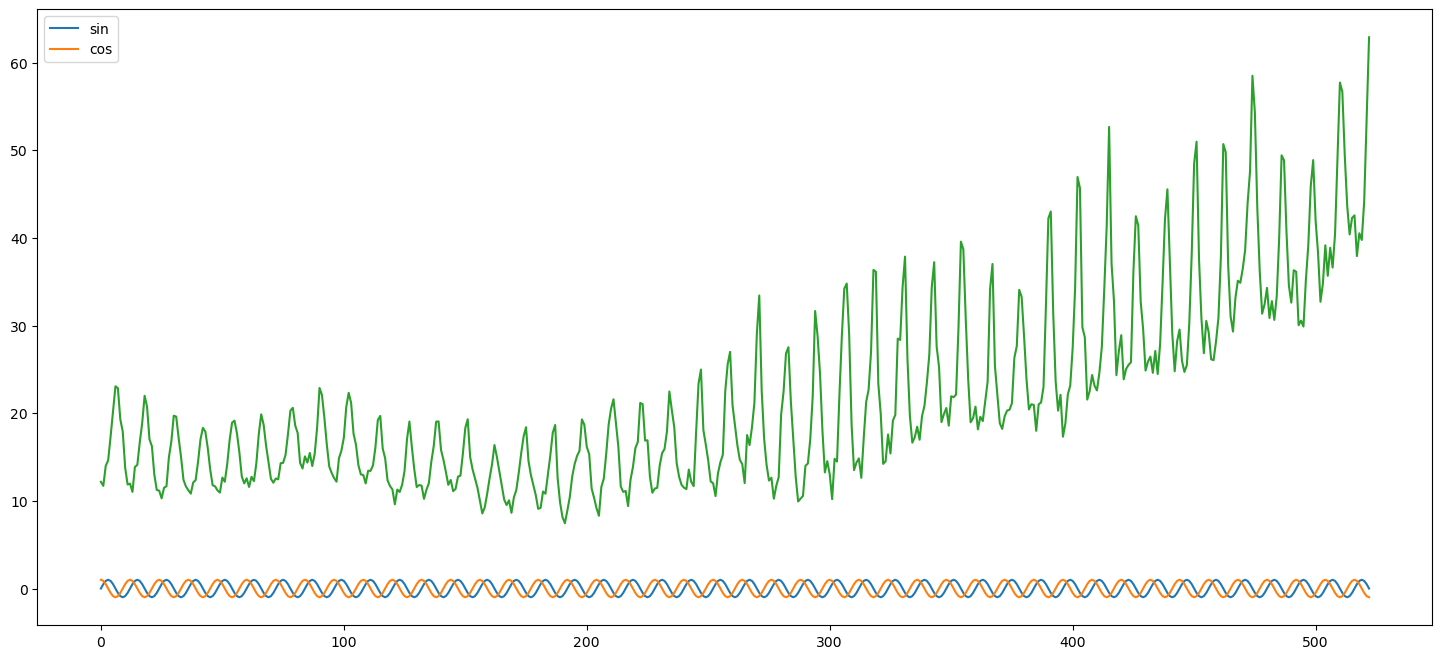

In [ ]:
ax = df_Z.loc[:, ['sin', 'cos']].plot(figsize=(18,8))
ax.plot(y);

Then we make and fit the model:

In [ ]:
model = sklearn.linear_model.LinearRegression()
model.fit(df_Z[['intercept', 'z', 'z2', 'z3', 'sin', 'cos']],y)

# YOUR CODE HERE

LinearRegression()

The following cell plots the learned model and the dataset $\mathcal{D}$ (blue points):

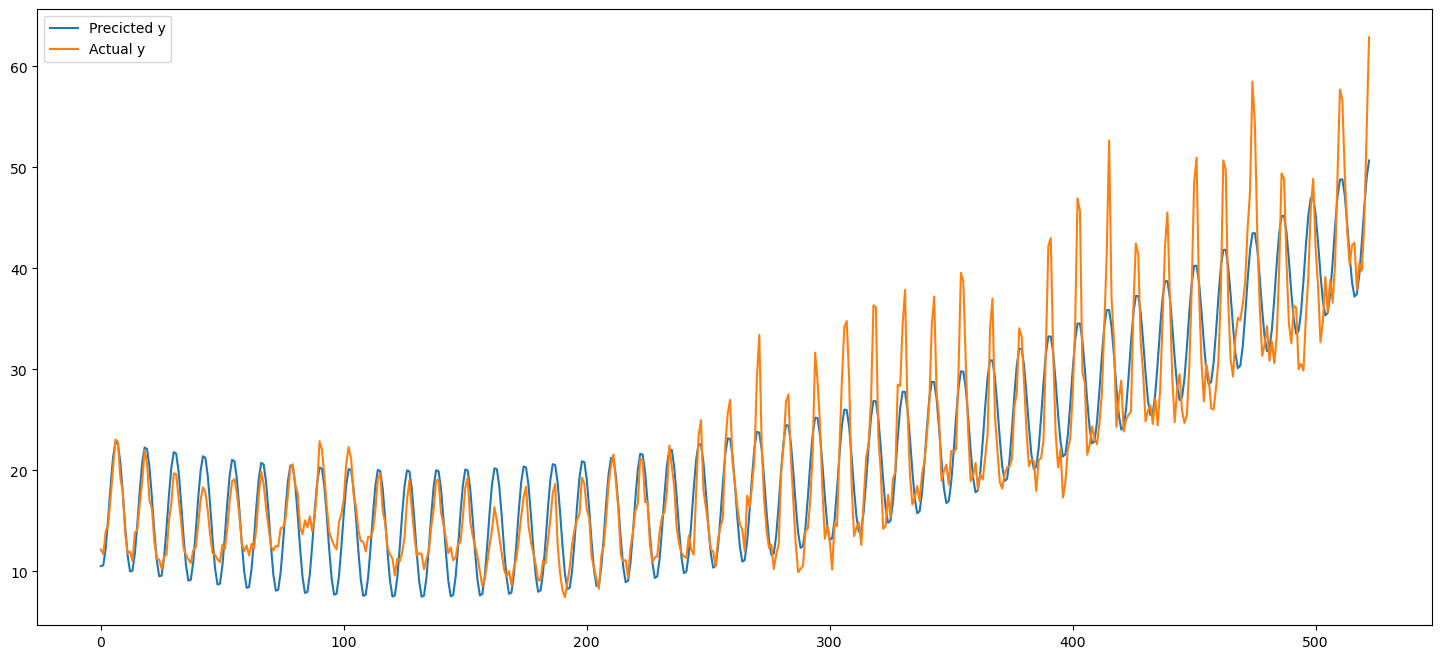

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))

# Compute the model's prediction
y_pred = model.predict(df_Z)
ax.plot(y_pred, label="Precicted y");

# Plot also the training points
ax.plot(y, label="Actual y")
ax.legend()
plt.show()

Then we use the model to (roughly) forecast the CO2 emission for the 5 next years:

In [ ]:
#np.arange(12 * 5) + df.index[-1] 
# df_Z_forecast = ...
# model.predict(...)
# ax.plot(...)

# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE